In [1]:
import numpy as np
import pandas as pd
import boto3
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ast
from datetime import timedelta
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import warnings
import sys
import itertools
import math

warnings.filterwarnings("ignore")
# import tslearn
try:
    import torch
except: pass

def largestDivisibleByKLessThanN(N, K):
    rem = N % K
    if(rem == 0):
        return N
    else:
        return N - rem

def zScore(x, dim=0):
    if isinstance(x, pd.core.frame.DataFrame):
        return (x - np.mean(x.to_numpy(), dim, keepdims=True)) / (np.std(x.to_numpy(), dim, keepdims=True) + 1e-7)
    else:
        return (x - np.mean(x, dim, keepdims=True)) / (np.std(x, dim, keepdims=True) + 1e-7)


def nanzScore(x, dim=0):
    if isinstance(x, pd.core.frame.DataFrame):
        return (x - np.nanmean(x.to_numpy(), dim, keepdims=True)) / (np.nanstd(x.to_numpy(), dim, keepdims=True) + 1e-7)
    else:
        return (x - np.nanmean(x, dim, keepdims=True)) / (np.nanstd(x, dim, keepdims=True) + 1e-7)

def get_user(user_id, start=None, end=None):
    user_sleep = df_sleep[df_sleep.user_id == user_id]#.dropna()
    user_bp = df_bodyport[df_bodyport.user_id == user_id]#.dropna()
    
    df2 = pd.merge(user_sleep, user_bp, on="date")

    if "creation_date" in df2.columns:
        for i in range(len(df2)):
            df2["creation_date"][i] = dt.datetime.strptime(df2["creation_date"][i], '%Y-%m-%d %H:%M:%S')
    
    df2.set_index(df2["date"], inplace=True)
    df2.sort_index(inplace=True)
    if start.empty == False:
        mask = pd.to_datetime(df2["date"]).between(start.astype(str)[0], end.astype(str)[0], inclusive=True)
        df2 = df2[mask]
    return df2


# Define s3 bucket
bucket = 'fouryouandme-study-data'

#List s3 keys
# get_matching_s3_keys(bucket, prefix='bump/') #Remove prefix to view non-BUMP data
bucket = '4youandme-study-data' # for SinC project
bucket = 'fouryouandme-study-data' # for 4YouandMe, Bump, CamCog or Bodyport project

# prefix = {study_name} or {study_name}/{source}
# sources: app_activities, bodyport, camcog, garmin, oura, redcap, rescuetime
# note camcog not accessible to bodyport (and vice a versa)
get_matching_s3_keys(bucket, prefix='bump/oura')

# Study IDs

key = 'bump/redcap/wave_4/study_ids.csv.gz'
df_studyID = pandas_from_csv_s3(bucket, key=key, compression='gzip')

# Some dataframes use 'record_id' instead of 'user_id'. 
# You'll need to match it up with df_studyID where'evidation_id' is 'user_id'
# NOTE: Very few examples of this. Birthing data is the important one

# Birthing Data
key = 'bump/redcap/wave_4/birthing_data_cohort_2_only.csv.gz'
df_birth = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date


df_birth = pd.merge(df_birth, df_studyID, on='record_id')
df_birth['user_id'] = df_birth.evidation_id

# There is a missing value in the birthing data. I'm removing it here
df_birth = df_birth.drop(index=50)

# Bodyport Wave 2
key = 'bump/bodyport/wave_4/bodyport.csv.gz'
df_bodyport = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# OPTIONAL: Convert date format
df_bodyport['date'] = pd.to_datetime(df_bodyport.event_date).dt.date 

# # Garmin Wave 2
# key = 'bump/garmin/wave_4/garmin_activities.csv.gz'
# df_gAct = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# df_gAct['date'] = pd.to_datetime(df_gAct.event_date).dt.date

# key = 'bump/garmin/wave_4/garmin_dailies.csv.gz'
# df_gDaily = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# df_gDaily['date'] = pd.to_datetime(df_gDaily.event_date).dt.date

# key = 'bump/garmin/wave_4/garmin_pulse_ox.csv.gz'
# df_gPulse = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# df_gPulse['date'] = pd.to_datetime(df_gPulse.event_date).dt.date

# key = 'bump/garmin/wave_4/garmin_respiration.csv.gz'
# df_gResp = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# df_gResp['date'] = pd.to_datetime(df_gResp.event_date).dt.date

# key = 'bump/garmin/wave_4/garmin_user_metrics.csv.gz'
# df_gUser = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# df_gUser['date'] = pd.to_datetime(df_gUser.event_date).dt.date

# Oura Wave 2
key = 'bump/oura/wave_4/oura_sleep.csv.gz'
df_sleep = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

key = 'bump/oura/wave_4/oura_activity.csv.gz'
df_activity = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

key = 'bump/oura/wave_4/oura_readiness.csv.gz'
df_readiness = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

# Surveys Wave 2
key = 'bump/app_activities/wave_4/surveys.csv.gz'
df_survey = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_survey['date'] = pd.to_datetime(df_survey.updated_at).dt.date

key = 'bump/app_activities/wave_4/quick_activities.csv.gz'
df_sam = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date

# Daily Symptom Survey Questions (1-7 Likert Scale) (See Data Dictionary) 
# nausea = df_survey[df_survey['question_id'] == 203]
# fatigue = df_survey[df_survey['question_id'] == 204]
# mood = df_survey[df_survey['question_id'] == 205]
# breath = df_survey[df_survey['question_id'] == 206]
# swollen = df_survey[df_survey['question_id'] == 207]
# walk = df_survey[df_survey['question_id'] == 208]
# remember = df_survey[df_survey['question_id'] == 209]

# dfs = [df_sleep, df_bodyport, df_birth, df_gAct, df_gDaily, df_gPulse, df_gResp, df_gUser, df_activity, df_readiness, df_survey, df_sam]
# dfs = [df_sleep, df_bodyport, df_birth, df_gDaily, df_activity, df_readiness, df_survey, df_sam]
dfs = [df_sleep, df_bodyport, df_birth, df_activity, df_readiness, df_survey, df_sam]

names = []
for df in dfs:
    [names.append(i) for i in df.columns.to_list()]
bodyport_features = [
    'heart_rate',
    'breath_average',
    'peripheral_fluid',
    'total_body_water_percent',
    'weight_kg'
]
oura_features = [
    'hr_lowest',
    'hr_average',
    'rmssd',
]
feature_names = bodyport_features + oura_features

outcome_names = [
    "walk",
    "fatigue",
    "mood",
    "nausea",
    "breath",
    "swollen",
    "remember",
]
date_list = ["d", "id_x", 
            "user_id_x", 
            "identity_id_x", 
            "created_at_x", 
            "updated_at_x", 
            "retrieved_at_x", 
            "subsource_x", 
            "event_date_x",
            "date", "id_y", 
            "user_id_y", 
            "identity_id_y", 
            "created_at_y", 
            "updated_at_y", 
            "retrieved_at_y", 
            "subsource_y", 
            "creation_date", 
            "event_date_y"]
#merge all data features
users = []
users_id = []
births = []
before_days = 14
for user_id in tqdm(df_sleep.user_id.unique()):
    birth = df_birth.loc[df_birth.user_id == user_id].reset_index()
    birthdate = birth["date"]
    if len(birth) > 0 and pd.isnull(birthdate[0]) == False:
        start = birthdate - pd.to_timedelta(before_days, unit='d') # pd.to_timedelta(100, unit='d')
        end = birthdate + pd.to_timedelta(0, unit='d')
        date_range = pd.date_range(start[0], end[0]-timedelta(days=1), freq='d')
        df = get_user(user_id, start, end)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        df = df[feature_names + date_list]
        if len(df) > 10 and df.isna().sum().max() < round(before_days/2): # max null counts in each col is less than 5
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            df = df.interpolate("linear", 0)
            users.append(df)
            users_id.append(user_id)
            births.append(birth)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-5c36qmmx because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
100%|██████████| 358/358 [00:05<00:00, 64.36it/s]


In [2]:
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from snf import datasets, compute, get_n_clusters

k = len(users) // 10
print(f'total number of users is {len(users)}')
print(f'k value is {k}')

def dtw_affinity(users, feature_names):
    affinities = []
    for feature in feature_names:
        dist_matrix = np.zeros((len(users), len(users)))
        for i in range(len(users)):
            df1 = users[i][feature].dropna().to_numpy()
            for j in range(i + 1, len(users)):
                df2 = users[j][feature].dropna().to_numpy()
                distance, path = fastdtw(df1, df2, dist=euclidean)
                dist_matrix[i][j] = distance
                dist_matrix[j][i] = distance
        affinity_matrix = compute.affinity_matrix(dist_matrix, K=k)
        affinities.append(affinity_matrix)
    return affinities
affinities = dtw_affinity(users, feature_names)

total number of users is 54
k value is 5


In [3]:
fused = compute.snf(affinities, K=k)

In [4]:
best, second = get_n_clusters(fused)
print(f'number of clusters can be {best} or {second}')

number of clusters can be 2 or 3


In [5]:
len(users)

54

In [6]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

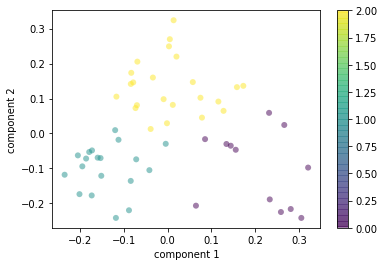

In [18]:
label = spectral_clustering(fused, n_clusters=3)
pipeline = Pipeline([('scaling', Normalizer()), 
                     ('pca', PCA(n_components=2))])
projected=pipeline.fit_transform(fused)
plt.scatter(projected[:,0], projected[:, 1],
            c=label,
            edgecolor='none', alpha=0.5,
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

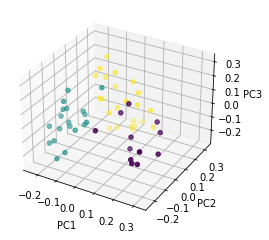

In [19]:
pipeline = Pipeline([('scaling', Normalizer()), 
                     ('pca', PCA(n_components=3))])
projected=pipeline.fit_transform(fused)
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected[:,0], projected[:,1], projected[:,2], c=label)

 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [20]:
cluster_index = {}
for label_num in np.unique(label):
    cluster_index[label_num] = list(np.where(label==label_num)[0])
    print(f'number of samples in cluster {label_num + 1}: {len(cluster_index[label_num])}')

number of samples in cluster 1: 12
number of samples in cluster 2: 19
number of samples in cluster 3: 23


In [21]:
feature_names

['heart_rate',
 'breath_average',
 'peripheral_fluid',
 'total_body_water_percent',
 'weight_kg',
 'hr_lowest',
 'hr_average',
 'rmssd']

In [22]:
birth.columns

Index(['index', 'record_id', 'redcap_event_name_x', 'birth_number',
       'birth_date', 'birth_scheduled', 'birth_scheduled_unsure',
       'birth_gestage', 'birth_mode', 'birth_c_type', 'birth_incision',
       'birth_indication', 'birth_apgar1', 'birth_apgar2', 'birth_abnormal1',
       'birth_describe1', 'birth_abnormal2', 'birth_describe2',
       'birth_maternal___1', 'birth_maternal___2', 'birth_maternal___3',
       'birth_maternal___4', 'birth_urine', 'birth_seizures',
       'birth_matmorbid', 'birth_describe', 'birth_stay', 'birth_stay_baby',
       'birth_stay_baby_yes', 'birth_feeding', 'birth_matleave',
       'birth_mat_leave_length', 'birthing_data_cohort_2_only_complete',
       'date', 'redcap_event_name_y', 'participant_id', 'sema4_id',
       'evidation_id', 'evidation_id_prior1', 'evidation_id_prior2',
       'evidation_id_c', 'study_ids_complete', 'user_id'],
      dtype='object')

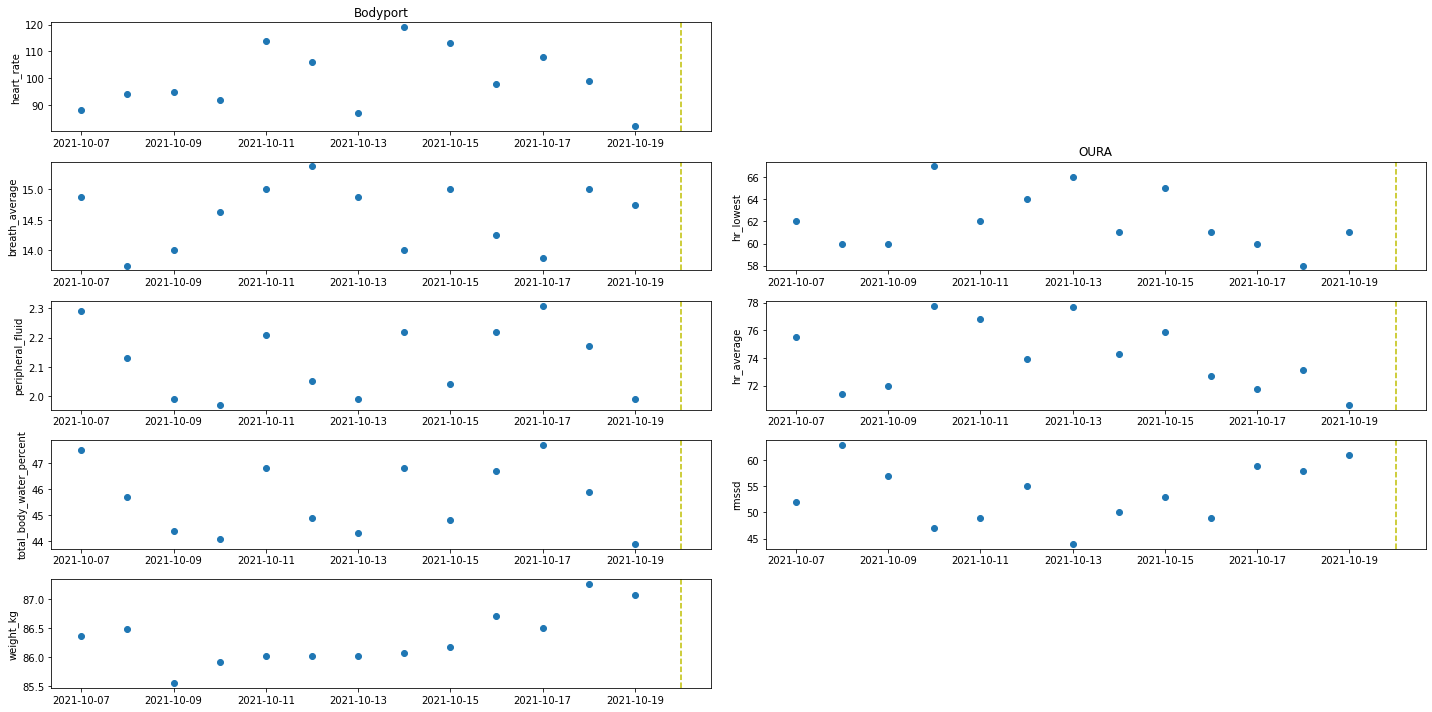

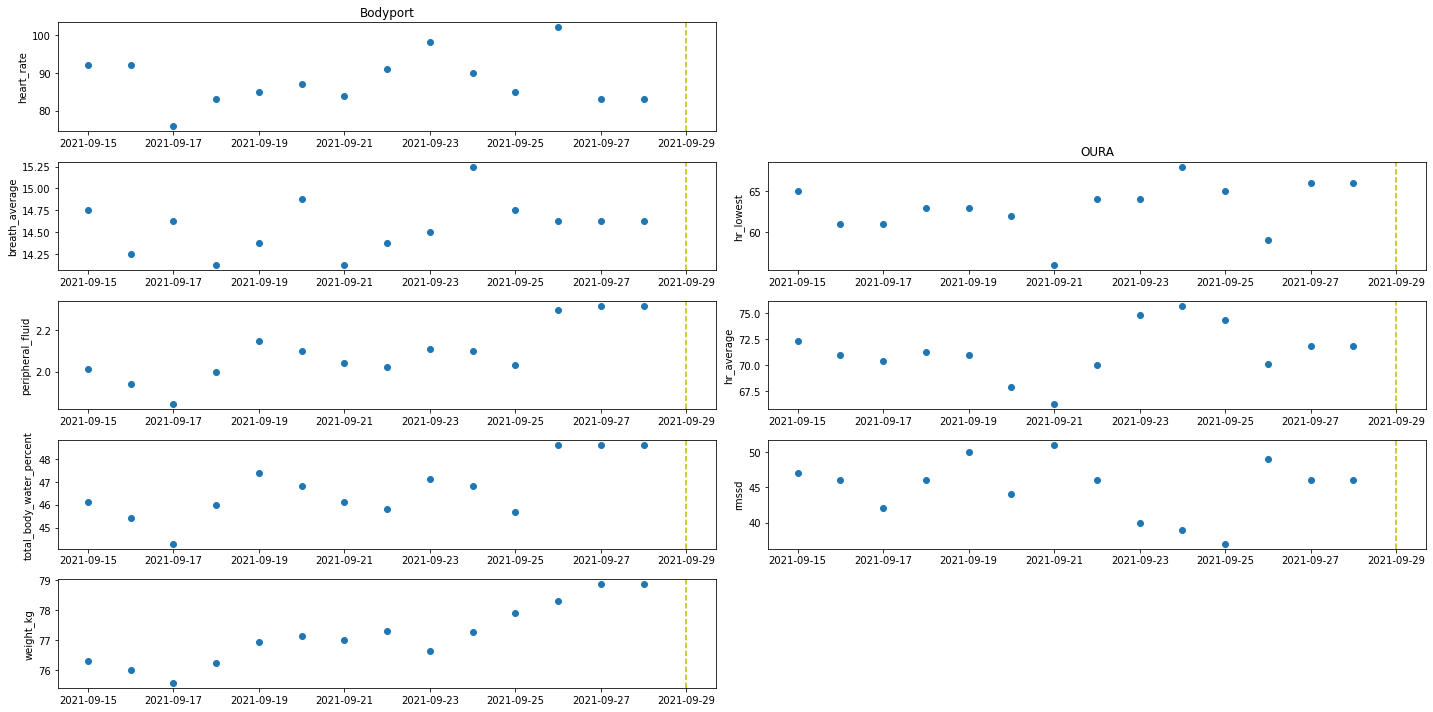

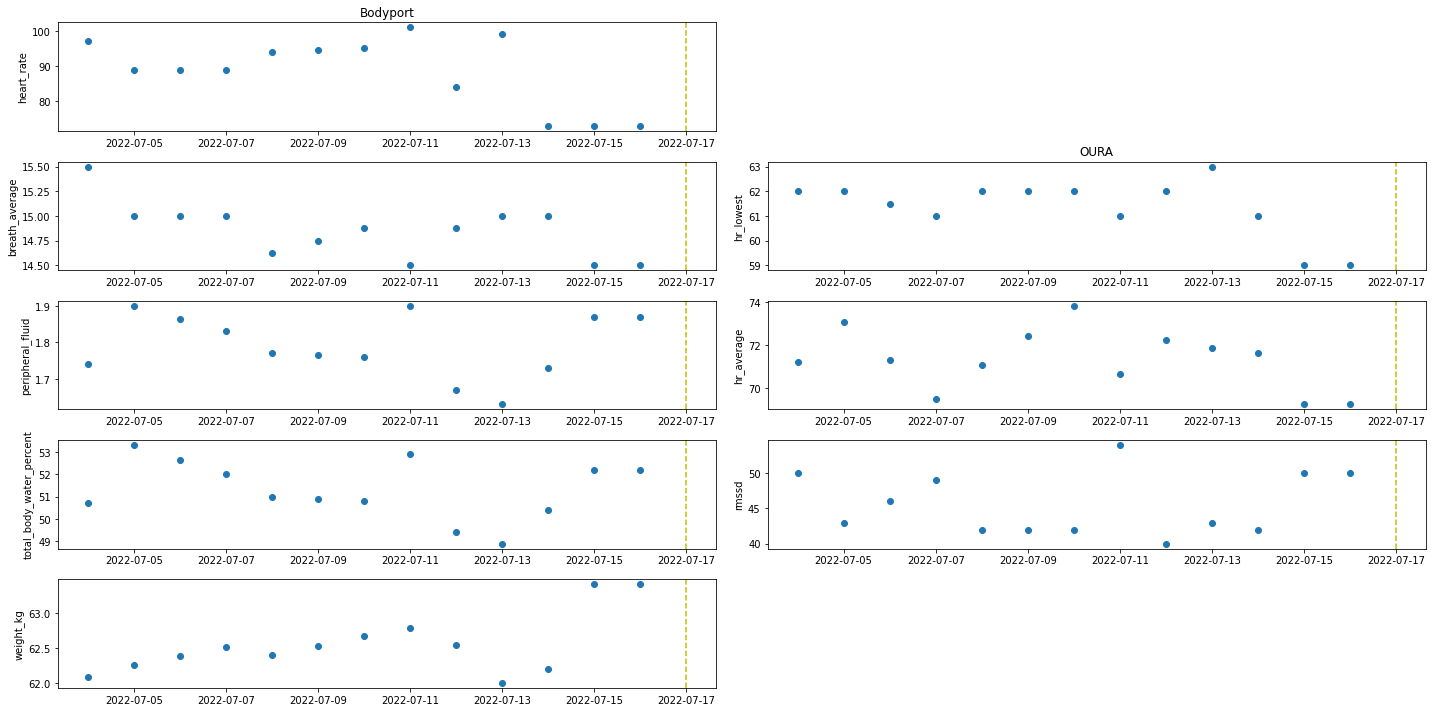

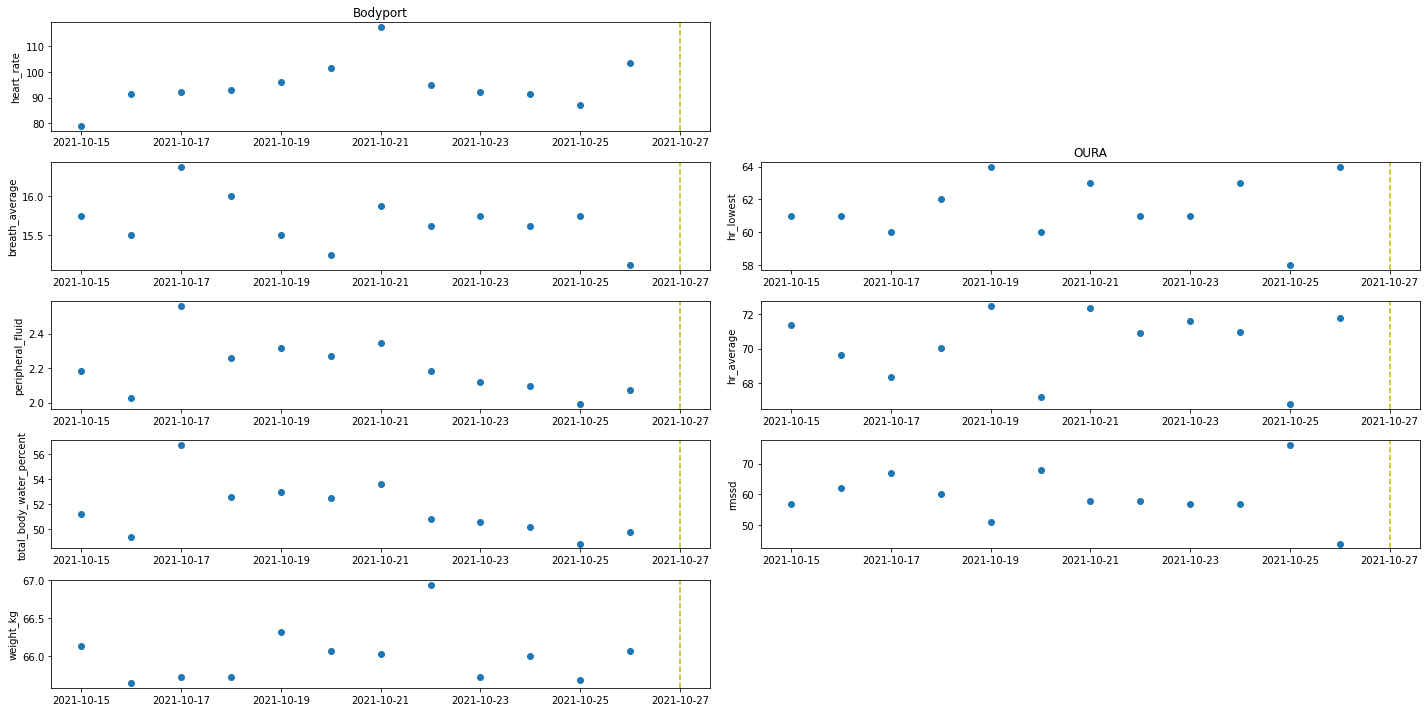

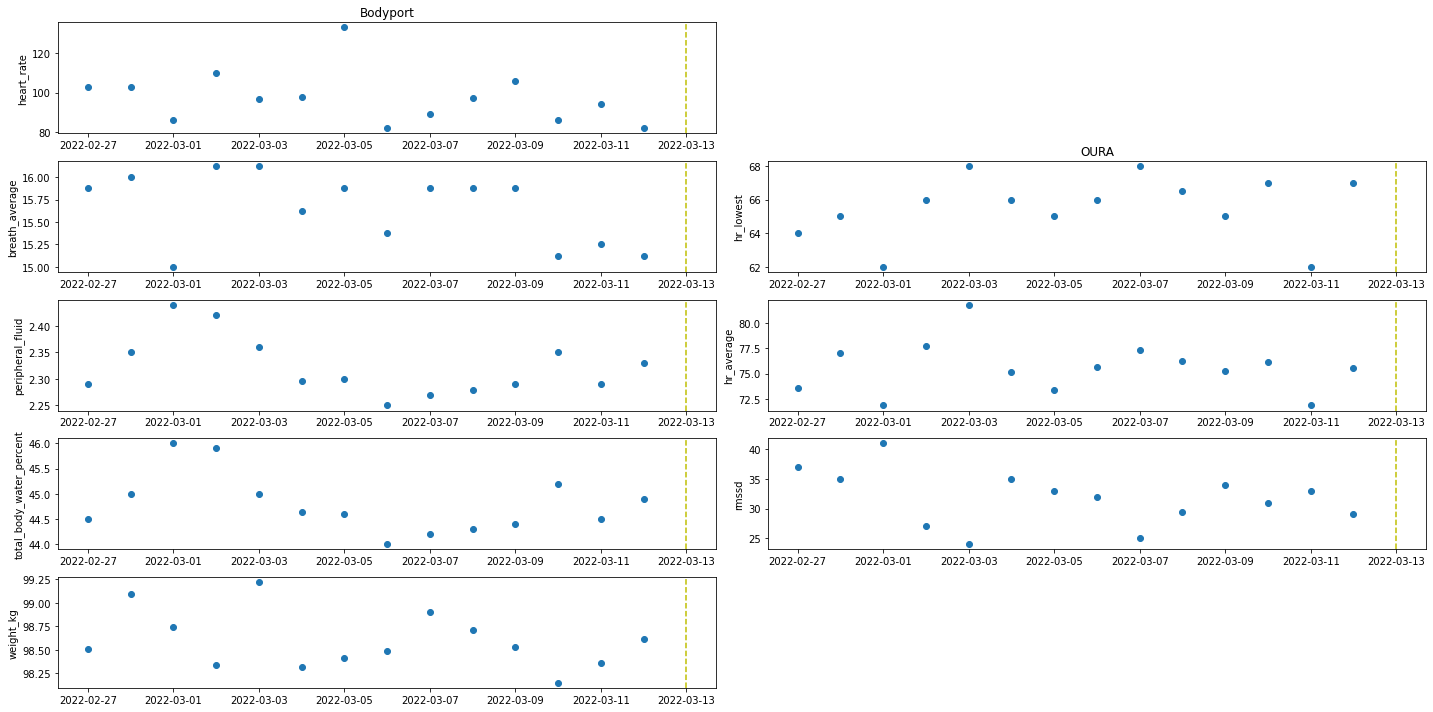

Error in callback <function flush_figures at 0x7fdf77a181e0> (for post_execute):


KeyboardInterrupt: 

In [19]:
for cluster_num in cluster_index:
    for index in cluster_index[cluster_num]:
        df = users[index]
        user = users_id[index]
        birth_date = df_birth.loc[df_birth.user_id == user]['birth_date'].tolist()[0]
        birth_date = dt.datetime.strptime(birth_date, '%Y-%m-%d')
        datelist = pd.date_range(birth_date - dt.timedelta(before_days), periods=before_days).tolist()
        row = max(len(oura_features), len(bodyport_features))
        fig = plt.figure(figsize=(20,10))
        i = 1
        for bodyport_feature in bodyport_features:
            
            ax = plt.subplot(row, 2, i)
            if i == 1:
                ax.set_title('Bodyport')
            ax.set_ylabel(bodyport_feature)
            ax.axvline(x=birth_date, color = 'y', ls='--')
            ax.scatter(datelist, df[bodyport_feature].tolist())
            i += 2

        i = 4
        for oura_feature in oura_features:
            ax = plt.subplot(row, 2, i)
            if i == 4: 
                ax.set_title('OURA')
            ax.set_ylabel(oura_feature)
            ax.axvline(x=birth_date, color = 'y', ls='--')
            ax.scatter(datelist, df[oura_feature].tolist())
            i += 2
        plt.tight_layout()
        plt.savefig(f'/mnt/results/snf_exploration/{len(cluster_index)}_clusters/cluster{cluster_num+1}/{user}.jpeg', bbox_inches='tight')


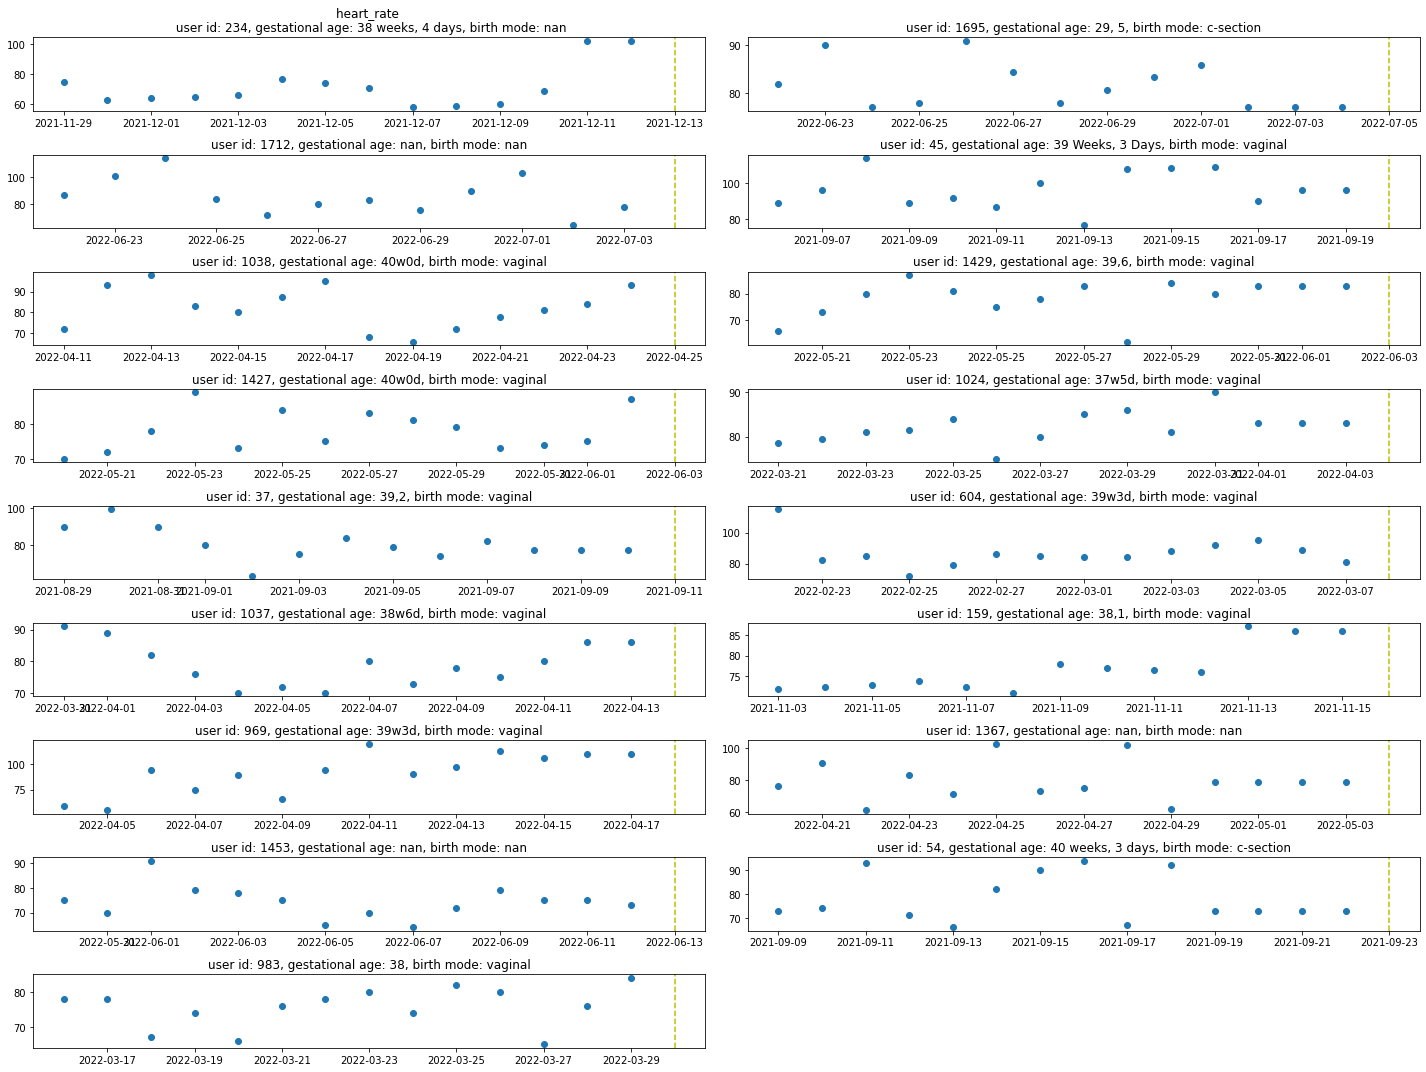

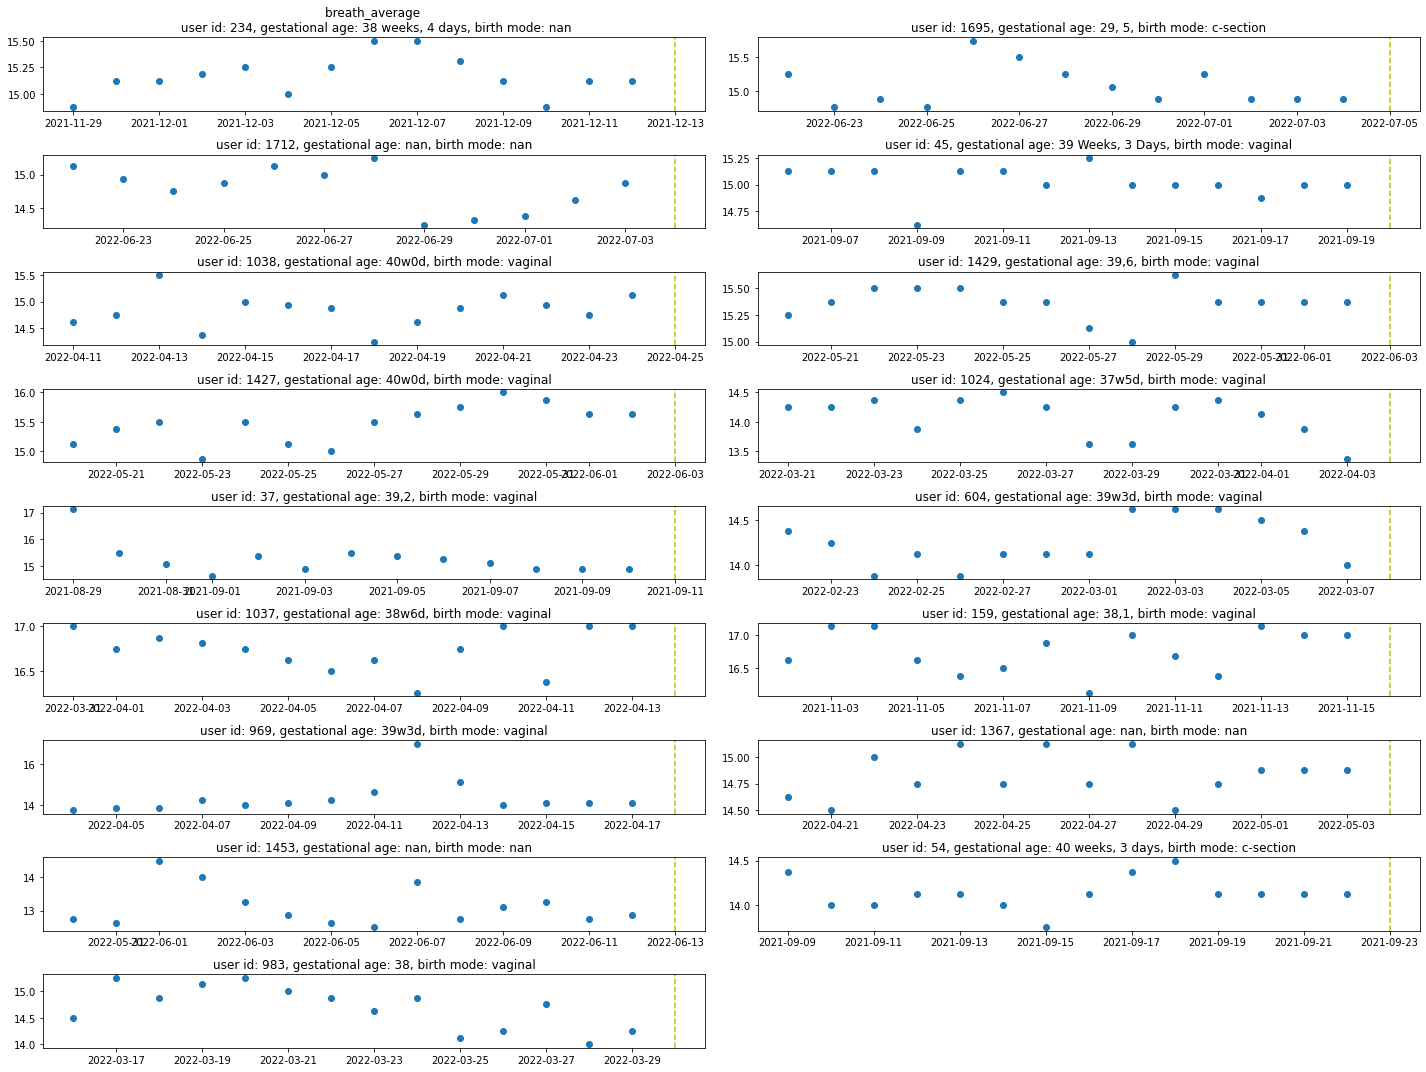

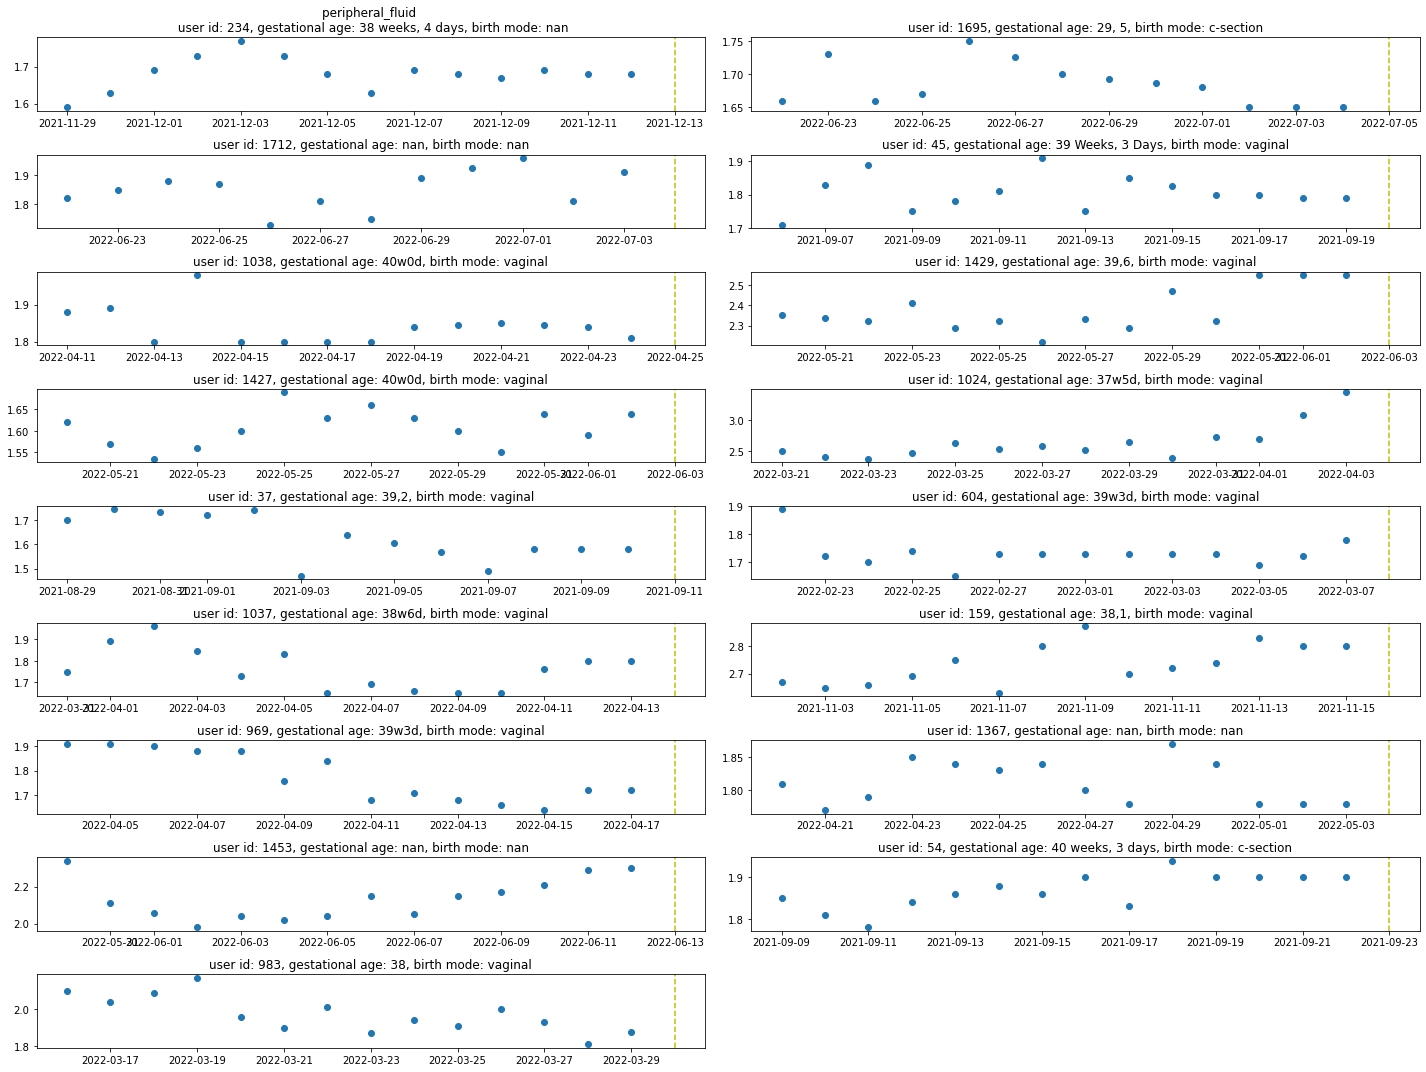

Error in callback <function flush_figures at 0x7fdd7e62f1e0> (for post_execute):


KeyboardInterrupt: 

In [17]:
birth_mode_type = {1: 'c-section', 2: 'vaginal'}
for cluster_num in cluster_index:
    for feature in feature_names:
        row = math.ceil(len(cluster_index[cluster_num]) / 2)
        fig = plt.figure(figsize=(20,15))
        for i, index in enumerate(cluster_index[cluster_num]):
            df = users[index]
            user = users_id[index]
            birth_date = df_birth.loc[df_birth.user_id == user]['birth_date'].tolist()[0]
            birth_date = dt.datetime.strptime(birth_date, '%Y-%m-%d')
            gestation_date = df_birth.loc[df_birth.user_id == user]['birth_gestage'].tolist()[0]
            birth_mode = df_birth.loc[df_birth.user_id == user]['birth_mode']
            if birth_mode.isnull().any() == False: 
                birth_mode = birth_mode_type[int(birth_mode.tolist()[0])]
            else:
                birth_mode = birth_mode.tolist()[0]
            datelist = pd.date_range(birth_date - dt.timedelta(before_days), periods=before_days).tolist()
            ax = plt.subplot(row, 2, i+1)
            if i == 0:
                ax.set_title(f'{feature} \n user id: {user}, gestational age: {gestation_date}, birth mode: {birth_mode}')
            else:
                ax.set_title(f'user id: {user}, gestational age: {gestation_date}, birth mode: {birth_mode}')
            ax.axvline(x=birth_date, color = 'y', ls='--')
            ax.scatter(datelist, df[feature].tolist())
        plt.tight_layout()
        plt.savefig(f'/mnt/results/snf_exploration/14days/{len(cluster_index)}_clusters/features/{feature}-cluster{cluster_num+1}.jpeg', bbox_inches='tight')


In [23]:
birth['birth_gestage']

0    NaN
Name: birth_gestage, dtype: object

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA, SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
pipeline = Pipeline([#('scaling', Normalizer()), 
                     ('pca', PCA(n_components=2))])
# pipeline = Pipeline([('scaling', Normalizer()), 
#                      ('pca', PCA(n_components=2))])
birth_users = df_birth.loc[df_birth['user_id'].isin(users_id)].reset_index()
nonnan_index = np.where(~np.isnan(birth_users['birth_mode']))[0]
birth_labels = birth_users['birth_scheduled'][nonnan_index].to_list()
projected=pipeline.fit_transform(fused)
projected = projected[nonnan_index,:]
plt.scatter(projected[:,0], projected[:, 1],
            c=birth_labels,
            edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('RdBu', 219)
           )
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3dx5nj_1 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


NameError: name 'df_birth' is not defined